<a href="https://colab.research.google.com/github/ShawnTayNWU/MSDS458/blob/MSDS458/MSDS458_Assignment_03_ExpD_NoEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 3

### Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br> 

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br> 


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

## Import packages 

In [61]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from timeit import default_timer as timer #import a timer
from datetime import datetime



In [62]:
#tf.get_logger().setLevel('INFO')

In [63]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [64]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.6.0


In [65]:
print("Keras version: ", keras.__version__)

Keras version:  2.6.0


### Functions For Research Assignment 

In [66]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 

In [67]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [68]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Mount Google Drive to Colab Environment

In [69]:
#from google.colab import drive
#drive.mount('/content/gdrive')

###  TensorFlow Datasets Information<br>
<div class="alert alert-block alert-info">
    <b> ag_news_subset</b><br>
    See https://www.tensorflow.org/datasets/catalog/ag_news_subset
    </div>

Get all the words in the documents (as well as the number of words in each document) by using the encoder to get the indices associated with each token and then translating the indices to tokens. But first we need to get the "unpadded" new articles so that we can get their length.

In [70]:
#register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

2021-11-05 22:20:08.111679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 22:20:08.120002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 22:20:08.120448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I1105 22:20:08.120977 139746796427136 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I1105 22:20:08.121622 139746796427136 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I1105 22:20:08.122714 139746796427136 download_and_prepare.py:138] download_and_prep

###  Exploratory Analysis AG News Subset

**Get information about the ag_news_subset dataset. We combined the training and test data for a total of 127,600 news articles.**

In [71]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [72]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


### Review Labels (Categories) 

In [73]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


In [74]:
# classes dictionary
categories =dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

The 127,600 news articles are evenly distributed among the 4 categories

In [75]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

### Preprocessing Data Create Input Pipeline

In [76]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2021-11-05 22:20:27.109191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 22:20:27.117019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 22:20:27.117492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I1105 22:20:27.118029 139971390793600 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I1105 22:20:27.118705 139971390793600 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I1105 22:20:27.119894 139971390793600 download_and_prepare.py:138] download_and_prep

In [77]:
####  Dataset Splits (Training, Test, Validation)
#### .8934 Training, .0470 Test, .0596 Validation

In [78]:
len(train_dataset),len(validation_dataset),len(test_dataset) 
# len(train_dataset),len(test_dataset) 

(114000, 6000, 7600)

### Review Distribution of Categorical Labels for the 114000 training data (news articles)

In [79]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

Review Example with Interger Label(text, label pairs):

Review Example with Interger Label Encoded Classification(text, label pairs):

In [80]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [81]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [82]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [83]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Cool autumn weather and apparent pent-up demand for clothing drove strong sales in October at Gap, Neiman Marcus and other national retailers, according to company reports issued Thursday.'
 b"Researchers at MIT are one step closer to creating patches for damaged hearts: They've used rat cells to construct a beating slice of cardiac tissue about the size of a dime. By Kristen Philipkoski."
 b'EAST RUTHERFORD, NJ -- The road to respectability for the Detroit Lions has been . . . the road. How ironic for a team that went three years and an NFL-record 24 games without winning away from Motown.']

labels:  [2 3 1]
texts:  [b'Reuters - U.S. stocks slid on Thursday, ending\\four days of gains as oil prices continued their march higher,\\but Google Inc. (GOOG.O) created a buzz as shares of the\\Internet search company surged on their debut.'
 b'China Aviation Oil (Singapore) Corp., which accounts for almost all of China #39;s jet fuel imports, said it #39;s in talks with suppliers 

In [84]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b'Napster, one of the world #39;s most well known music downloading services, has signed a lucrative deal with Dwango Wireless that could see a mobile phone capable of downloading ringtones from Napster by 2005.'
 b'Ten or more years of mobile phone use can dramatically increase the risk of developing a benign tumor on the auditory nerve, according to a study conducted by the Institute of Environmental Medicine at Karolinska Institutet in Stockholm.'
 b'Reuters - The United States will help the\\millions devastated by the Indian Ocean tsunami, but an effort\\on the scale of the post-World War II Marshall Plan is probably\\not needed, Secretary of State Colin Powell said on Tuesday.']

labels:  ['Sci/Tech', 'Sci/Tech', 'World']

texts:  [b'Reuters - U.S. stocks opened near unchanged on\\Friday after mixed corporate results showed Web search company\\Google Inc.   had better-than-forecast earnings, but\\software maker Microsoft Corp.  gave a revenue forecast\\that lagged Wall St

## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [85]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [86]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

1000

In [87]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

Here are the 20 least frequent words.

In [88]:
vocab[-20:]

array(['black', 'turn', 'build', 'countrys', 'advanced', 'whose',
       'crisis', 'create', '23', 'sources', 'body', 'militant', 'hope',
       'event', 'started', 'ready', 'jones', 'lawsuit', 'focus',
       'singapore'], dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [89]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 28,  25, 248, 931, 360,   1,   1,  29,   1, 674, 471, 529, 233,
        200,   1,  49,  67,   1, 281,   1, 173, 100,  71, 650,   3, 636,
          1,   1, 389, 331, 866,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [472,  71, 925,  66, 682,   1,   1,  14,  13,  95, 169, 257, 850,
          9,   2,  39,  86,   1,   3,   1,   4, 347,   2, 418, 166,   1,
          1,   1,   1,   1,   1,   1,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [ 40, 101,   8,   2,   1, 719, 186,  11,   1,   1,   7,   1,   1,
          1, 605,   3,   1,   1,  52,   9,   3,   1,   1,   7,   1,   1,
          1,   1,  18,  50, 605,  15,   2,   1, 317, 606,  20, 192,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [90]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Reuters - U.S. stocks opened near unchanged on\\Friday after mixed corporate results showed Web search company\\Google Inc.   had better-than-forecast earnings, but\\software maker Microsoft Corp.  gave a revenue forecast\\that lagged Wall Street expectations.'
Round-trip:  reuters us stocks opened near [UNK] [UNK] after [UNK] corporate results showed web search [UNK] inc had [UNK] earnings [UNK] maker microsoft corp gave a revenue [UNK] [UNK] wall street expectations                             

Original:  b'Intel Corp. named President Paul S. Otellini as its next chief executive officer, for the first time choosing a non-engineer to run the world\'s largest computer-chip maker.&lt;FONT face="verdana,MS Sans Serif,arial,helvetica" size="-2" color="#666666"&gt;&lt;B&gt;-Bloomberg News&lt;/B&gt;&lt;/FONT&gt;'
Round-trip:  intel corp named president paul [UNK] [UNK] as its next chief executive officer for the first time [UNK] a [UNK] to run the worlds largest [UNK] [UNK] [U

## Create the model: Single Layer CNN (Experiment D1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

In [91]:
from keras import backend as K
K.clear_session()

model1 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Conv1D(32, 7,activation='relu')
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.GlobalMaxPool1D()
                              ,tf.keras.layers.Dense(4, activation=tf.nn.softmax) 
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model: Single Layer CNN (Experiment D1)

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [92]:
model1.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [93]:
print([layer.supports_masking for layer in model1.layers])

[False, True, False, True, True, False, True]


## Train the model: Single Layer CNN (Experiment D1)

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [94]:
start=datetime.now()

history1 = model1.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end=datetime.now()
print("Experiment D1 time:", end-start) 

Epoch 1/200
1782/1782 [==============================] - 10s 5ms/step - loss: 0.9566 - accuracy: 0.6462 - val_loss: 0.6207 - val_accuracy: 0.8333
Epoch 2/200
1782/1782 [==============================] - 9s 5ms/step - loss: 0.4509 - accuracy: 0.8406 - val_loss: 0.5305 - val_accuracy: 0.8552
Epoch 3/200
1782/1782 [==============================] - 9s 5ms/step - loss: 0.4215 - accuracy: 0.8499 - val_loss: 0.5007 - val_accuracy: 0.8531
Epoch 4/200
1782/1782 [==============================] - 9s 5ms/step - loss: 0.4096 - accuracy: 0.8533 - val_loss: 0.4989 - val_accuracy: 0.8526
Experiment D1 time: 0:00:36.643398


In [95]:
test_loss, test_acc = model1.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 4ms/step - loss: 0.5086 - accuracy: 0.8470
Test Loss: 0.5085967183113098
Test Accuracy: 0.8469736576080322


## Plotting Performance Metrics: Single Layer CNN (Experiment D1)

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [96]:
history_dict1 = history1.history
history_dict1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [97]:
history1_df=pd.DataFrame(history_dict1)
history1_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.957,0.646,0.621,0.833
1,0.451,0.841,0.531,0.855
2,0.422,0.850,0.501,0.853
3,0.410,0.853,0.499,0.853


In [98]:
losses = history1.history['loss']
accs = history1.history['accuracy']
val_losses = history1.history['val_loss']
val_accs = history1.history['val_accuracy']
epochs = len(losses)

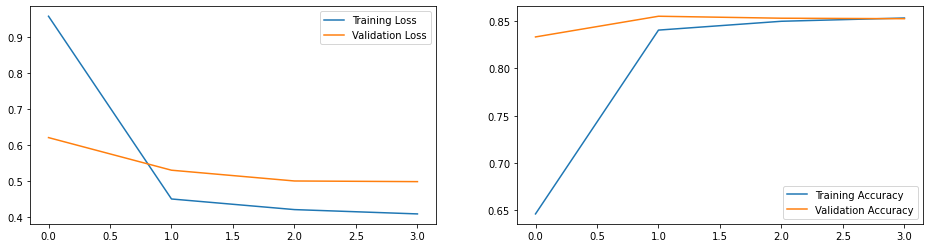

In [99]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Architecture Summary: Single Layer CNN (Experiment D1)

In [100]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          14368     
_________________________________________________________________
dense (Dense)                (None, None, 64)          2112      
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2

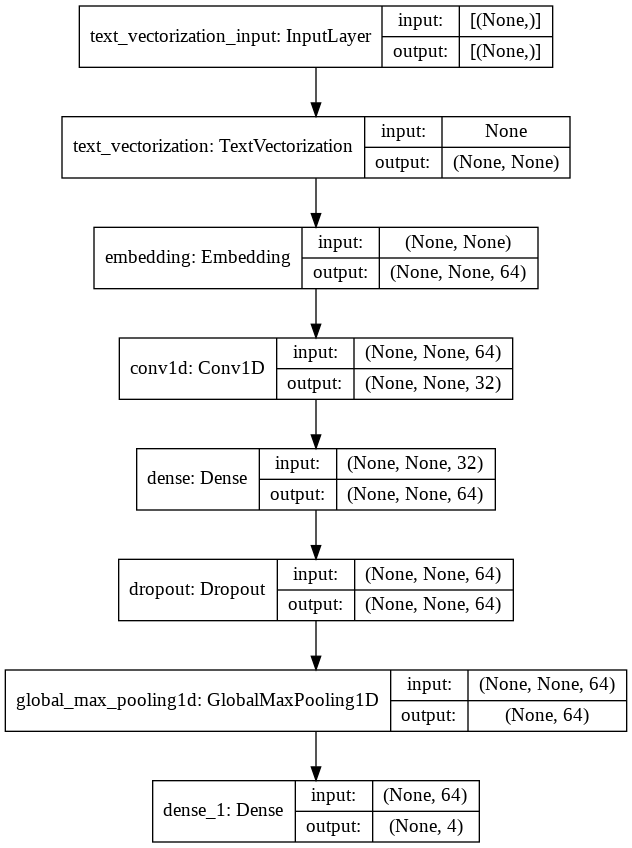

In [101]:
keras.utils.plot_model(model1, "BiDirectionalLSTM.png", show_shapes=True)

##Create model: 2 Layer CNN (Experiment D2)


Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [102]:
from keras import backend as K
K.clear_session()

model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Conv1D(32, 7,activation='relu')
                              ,tf.keras.layers.MaxPool1D(2)
                              ,tf.keras.layers.Conv1D(32, 7,activation='relu')
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.GlobalMaxPool1D()
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(4, activation=tf.nn.softmax) 
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [103]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [104]:
start=datetime.now()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )


end=datetime.now()
print("Experiment D2 time:", end-start)

Epoch 1/200
1782/1782 [==============================] - 10s 5ms/step - loss: 0.5889 - accuracy: 0.7780 - val_loss: 0.4221 - val_accuracy: 0.8526
Epoch 2/200
1782/1782 [==============================] - 9s 5ms/step - loss: 0.4571 - accuracy: 0.8427 - val_loss: 0.4073 - val_accuracy: 0.8599
Epoch 3/200
1782/1782 [==============================] - 9s 5ms/step - loss: 0.4288 - accuracy: 0.8522 - val_loss: 0.4051 - val_accuracy: 0.8578
Epoch 4/200
1782/1782 [==============================] - 9s 5ms/step - loss: 0.4059 - accuracy: 0.8603 - val_loss: 0.4035 - val_accuracy: 0.8667
Epoch 5/200
1782/1782 [==============================] - 9s 5ms/step - loss: 0.3811 - accuracy: 0.8680 - val_loss: 0.4007 - val_accuracy: 0.8594
Epoch 6/200
1782/1782 [==============================] - 9s 5ms/step - loss: 0.3578 - accuracy: 0.8766 - val_loss: 0.4430 - val_accuracy: 0.8516
Experiment D2 time: 0:00:55.876049


In [105]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 0s 3ms/step - loss: 0.4309 - accuracy: 0.8511
Test Loss: 0.4308550953865051
Test Accuracy: 0.8510526418685913


## Plotting Performance Metrics: 2 Layer CNN (Experiment D2)

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [106]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [107]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
1,0.457,0.843,0.407,0.860
2,0.429,0.852,0.405,0.858
3,0.406,0.860,0.404,0.867
4,0.381,0.868,0.401,0.859
5,0.358,0.877,0.443,0.852


In [108]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

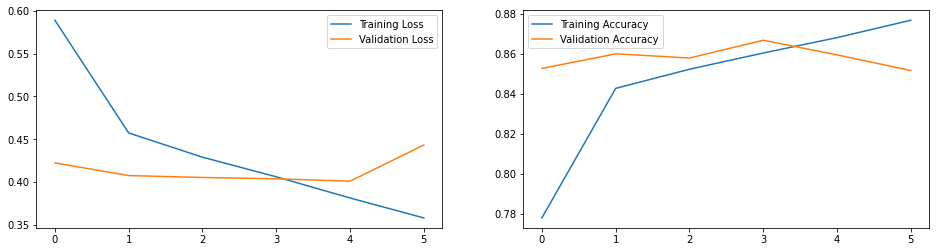

In [109]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [110]:
preds = model2.predict(test_dataset)

In [111]:
preds.shape

(7600, 4)

In [112]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [113]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.00%,100.00%,0.03%,0.20%,99.98%,0.03%,0.67%,21.93%,99.50%,0.41%,100.00%,0.08%,0.50%,95.23%,100.00%
Sports,100.00%,0.00%,0.00%,99.79%,0.00%,0.00%,99.28%,75.33%,0.01%,0.01%,0.00%,0.08%,0.00%,0.27%,0.00%
Business,0.00%,0.00%,2.94%,0.01%,0.00%,8.62%,0.01%,0.01%,0.06%,98.01%,0.00%,0.16%,99.15%,3.70%,0.00%
Sci/Tech,0.00%,0.00%,97.04%,0.01%,0.02%,91.35%,0.05%,2.73%,0.44%,1.57%,0.00%,99.69%,0.35%,0.80%,0.00%


#### Model Architecture Summary: 2 Layer CNN (Experiment D2)

In [114]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          14368     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          7200      
_________________________________________________________________
dense (Dense)                (None, None, 64)          2112      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0

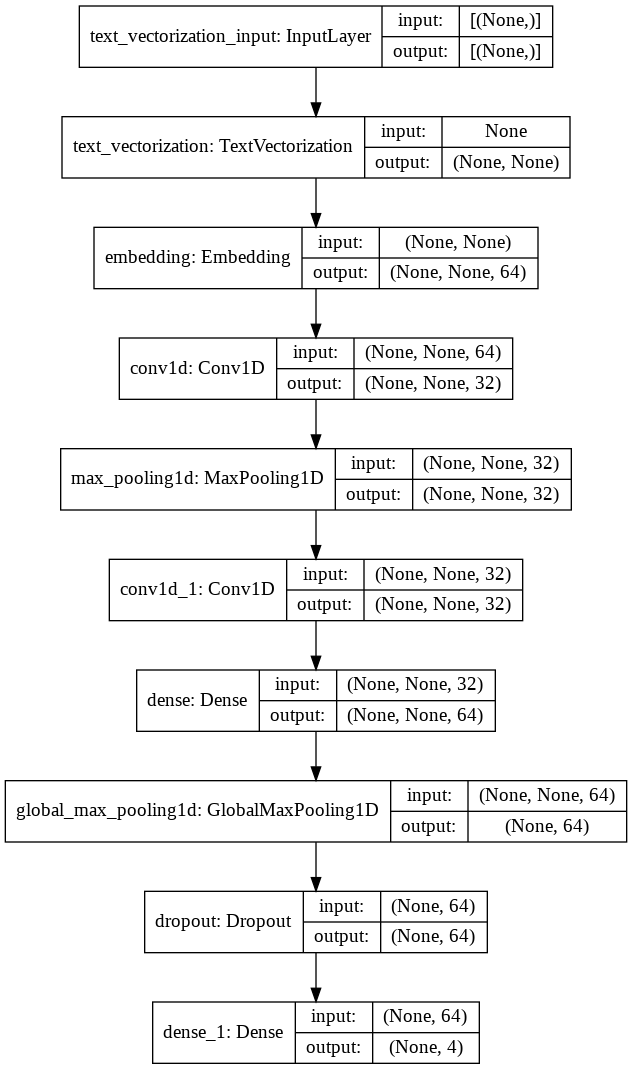

In [115]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)